# Image Classification with TensorFlow 2.0

In this project, we will build two models to classify a series of images into one of ten classes. These images have a( 32×32×3 ) shape.

In [81]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [82]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 144

Loading the data from the TensorFlow library

In [83]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

Plotting the first few images from the training set with their classes

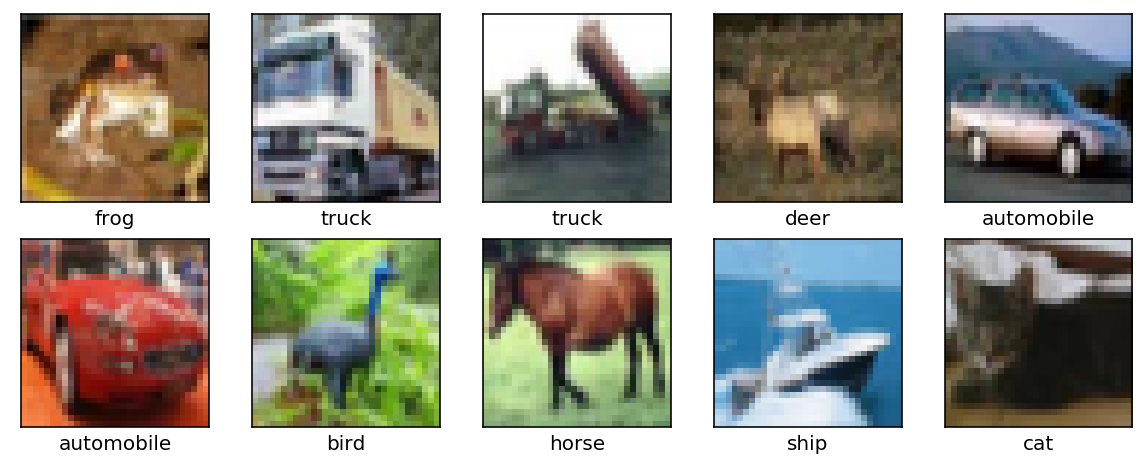

In [84]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

We will now build the first model: we will calculate a distance between two images by assuming that it is the average difference between the colors of the corresponding pixels in the two images
The distance is calculated as follows :
$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

In [85]:
#Implementation of the distance function
@tf.function
def delta_func2(images, base):
    delta = images-base
    deltar = delta[:,:,:,0]*delta[:,:,:,0]
    deltag = delta[:,:,:,1]*delta[:,:,:,1]
    deltab = delta[:,:,:,2]*delta[:,:,:,2]
    rbar = (images[:,:,:,0] + base[:,:,0])/2
    c = tf.sqrt(2*deltar + 4*deltag + 3*deltab + rbar*(deltar - deltab))
    return tf.reduce_mean(c,(1,2))

In [86]:
delta_first_test = tf.reduce_mean(np.array(delta_func2(train_images,test_images[0])))

In [87]:
float(np.array(delta_first_test))

0.8154433818176455

We now build a 'typical' image to compare to for each class: we start with random pixel values, and use a gradient descent optimiser to  minimise the average distance between the typical image and all training images of the same class

In [88]:
label = 6
indices_label = [i for i in range(len(train_labels)) if train_labels[i][0]==label]
ims = train_images[indices_label]

In [ ]:
typical = tf.Variable(np.random.uniform(0,1,(32,32,3)), name="typical_image",dtype='float64')
error = tf.reduce_mean(delta_func2(ims, typical))

In [90]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
loss = lambda: tf.reduce_mean(delta_func2(ims, typical))
for i in tqdm(range(1000)):
    opt.minimize(loss, var_list=[typical])

Here is an example of the typical image for the Frog class

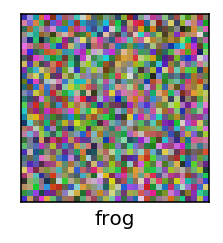

In [91]:
plt.figure(figsize=(10,10))
plt.subplot(5,5,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(typical.numpy(), cmap=plt.cm.binary)
plt.xlabel(class_names[6])
plt.show()

Now building typical images for all 10 classes

In [ ]:
typical_classes = []
for i in tqdm(range(10)):
    label = i
    indices_label = [i for i in range(len(train_labels)) if train_labels[i][0]==label]
    ims = train_images[indices_label]
    typical = tf.Variable(np.random.uniform(0,1,(32,32,3)), name="typical_image",dtype='float64')
    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    loss = lambda: tf.reduce_mean(delta_func2(ims, typical))
    for i in tqdm(range(1000)):
        opt.minimize(loss, var_list=[typical])
    typical_classes.append(typical.numpy())

In [ ]:
np.save('typical_classes.npy',typical_classes)

In [92]:
typical_classes = np.load('typical_classes.npy')

Below are all typical images

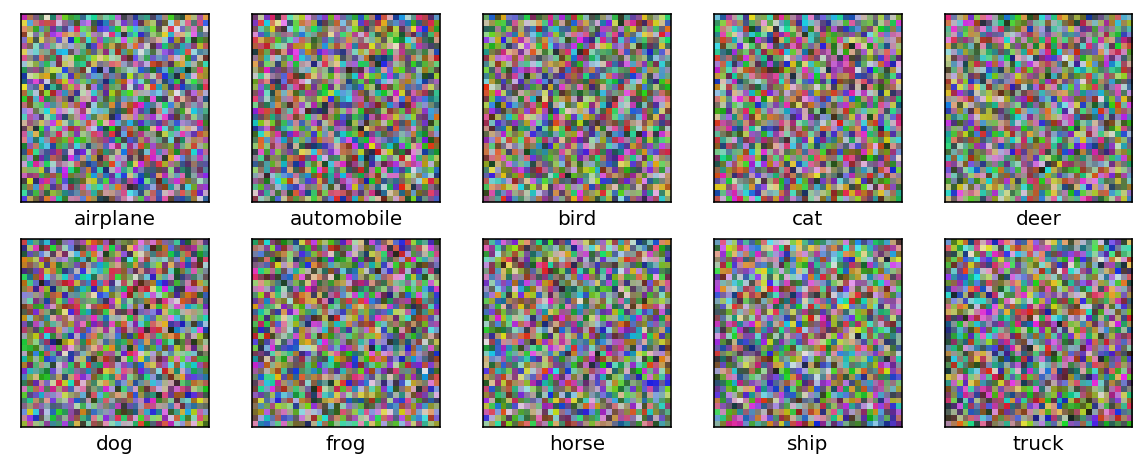

In [93]:
plt.figure(figsize=(10,10))
for i, classe in enumerate(typical_classes):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(typical_classes[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[i])
plt.show()

We now compute the distance between each image and each typical images

In [94]:
deltas = [np.array(delta_func2(test_images,i)) for i in typical_classes]

To predict the class, we choose the class with the smallest distance to the image we are classifying

In [95]:
predicted_classes = [np.argmin(np.transpose(deltas)[i]) for i in range(len(test_images))]


In [96]:
accuracy = sum([1 if predicted_classes[i] == test_labels[i] else 0 
                for i in range(len(test_labels))])/len(test_labels)
print(accuracy)

0.1796


As we can see, the accuracy of the classification is not very good. The distance is not a good metric.

We now build the second model : convolutional neural network

In [97]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [98]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [100]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [101]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 37s 738us/sample - loss: 1.5348 - accuracy: 0.4381 - val_loss: 1.2806 - val_accuracy: 0.5443
Epoch 2/10
50000/50000 [==============================] - 36s 715us/sample - loss: 1.1554 - accuracy: 0.5880 - val_loss: 1.1051 - val_accuracy: 0.6125
Epoch 3/10
50000/50000 [==============================] - 34s 681us/sample - loss: 1.0060 - accuracy: 0.6466 - val_loss: 0.9905 - val_accuracy: 0.6479
Epoch 4/10
50000/50000 [==============================] - 36s 716us/sample - loss: 0.9069 - accuracy: 0.6806 - val_loss: 0.9446 - val_accuracy: 0.6645
Epoch 5/10
50000/50000 [==============================] - 34s 685us/sample - loss: 0.8319 - accuracy: 0.7084 - val_loss: 0.9335 - val_accuracy: 0.6789
Epoch 6/10
50000/50000 [==============================] - 34s 689us/sample - loss: 0.7768 - accuracy: 0.7265 - val_loss: 0.8562 - val_accuracy: 0.7049
Epoch 7/10
50000/50000 [====================

As we can see, the convolutional neural network model is much more accurate than the previous one, reaching an accuracy of 71.45%